In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.datasets import make_circles, make_classification,make_blobs, make_moons, make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import math
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

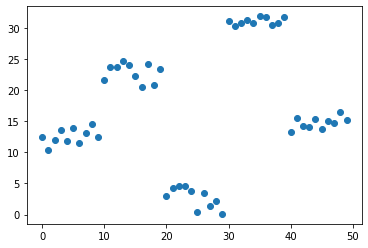

In [153]:
def get_data(num = 1):
    if num == 1:
        X = np.arange(0, 2*np.pi, 0.1).reshape(-1,1)
        y = np.sin(X).reshape(-1)
    elif num == 2:
        
        X = np.arange(0,50).reshape(-1,1)

        y1 = np.random.uniform(10,15,10)
        y2 = np.random.uniform(20,25,10)
        y3 = np.random.uniform(0,5,10)
        y4 = np.random.uniform(30,32,10)
        y5 = np.random.uniform(13,17,10)

        y = np.concatenate((y1,y2,y3,y4,y5))
    
    plt.scatter(X, y)
    
    return X, y

X, y = get_data(2)


In [178]:
from sklearn.metrics import mean_squared_error

class MyGbmRegressor:
    def __init__(self, 
                 max_depth=1, 
                 n_estimators=10,
                 verbose=True,
                 random_state=None):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.verbose = verbose
        self.random_state = random_state
        self.base_models = []
    
    def _get_estimator(self):
        # Will use tree as base estimator
        return DecisionTreeRegressor(max_depth=self.max_depth, splitter='best', criterion='mse', random_state=self.random_state)
    
    def fit(self, X, y):
        def get_init_prediction(y):
            sample_count = len(y)

            F0 = np.zeros(sample_count)
            F0[:] = y.sum() / sample_count

            return F0
        
        def get_loss_func(y, y_pred):
            return mean_squared_error(y, y_pred)
        
        def calc_pseudo_residuals(y, y_pred):
            return (y - y_pred)
        
        sample_count = len(y)
        
        predictions = np.zeros((self.n_estimators+1, sample_count))
        residuals = np.zeros((self.n_estimators+1, sample_count))
        
        predictions[0] = get_init_prediction(y)
        residuals[0] = calc_pseudo_residuals(y, predictions[0])
        
        for m in range(1, self.n_estimators+1):
            last_pred = predictions[m-1]
            last_residuals = residuals[m-1]
            
            base_model = self._get_estimator()
            
            base_model.fit(X, last_residuals)
            res_pred = base_model.predict(X)
            
            predictions[m] = predictions[m-1] + res_pred
            residuals[m] = calc_pseudo_residuals(y, predictions[m])
            
            self.base_models.append(base_model)
            print(f"{m}:Loss: {get_loss_func(y, predictions[m]):.3f}, "+ \
                  f"diff loss: {get_loss_func(y, predictions[m])-get_loss_func(y, predictions[m-1]):.3f}, " + \
                  f"residuals: Mean {np.mean(residuals[m]):.3f}, Std {np.std(residuals[m]):.3f}")
        
        self.X = X
        self.y = y
        self.predictions = predictions
        self.residuals = residuals
        
        return self

    def plot_steps(self):
        def get_optimal_axes():
            ncols = 2
            nrows = self.n_estimators+1
            
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True)

            fig.set_figheight(5*nrows)
            fig.set_figwidth(6*ncols)

            return axes
        
        axes = get_optimal_axes()
        
        for i in range(self.n_estimators+1):
            axes[i][0].scatter(self.X, self.y, c='b',s=10, label='y')
            axes[i][0].plot(self.X, self.predictions[i], c='r', label='pred')
            axes[i][0].legend()
            
            axes[i][1].scatter(self.X, self.residuals[i], c='g',s=10, label='residuals')
            axes[i][1].axhline(y=0, c='c')
            axes[i][1].legend()

model = MyGbmRegressor(n_estimators=30)
model.fit(X, y)

1:Loss: 68.650, diff loss: -24.894, residuals: Mean 0.000, Std 8.286, mse 68.64978012826025
2:Loss: 51.975, diff loss: -16.675, residuals: Mean 0.000, Std 7.209, mse 51.974703077776276
3:Loss: 45.722, diff loss: -6.253, residuals: Mean -0.000, Std 6.762, mse 45.72154918384479
4:Loss: 29.092, diff loss: -16.629, residuals: Mean -0.000, Std 5.394, mse 29.092346542051835
5:Loss: 21.702, diff loss: -7.391, residuals: Mean 0.000, Std 4.658, mse 21.701589812366073
6:Loss: 18.417, diff loss: -3.285, residuals: Mean 0.000, Std 4.291, mse 18.416809043616844
7:Loss: 11.755, diff loss: -6.662, residuals: Mean -0.000, Std 3.429, mse 11.755002832691277
8:Loss: 9.257, diff loss: -2.498, residuals: Mean 0.000, Std 3.043, mse 9.25682550359419
9:Loss: 7.797, diff loss: -1.460, residuals: Mean 0.000, Std 2.792, mse 7.796922939705649
10:Loss: 5.452, diff loss: -2.345, residuals: Mean -0.000, Std 2.335, mse 5.451990229481339
11:Loss: 4.573, diff loss: -0.879, residuals: Mean 0.000, Std 2.138, mse 4.572640

In [288]:
tr = model.base_models[0].tree_
tr.threshold


SyntaxError: invalid syntax (<ipython-input-288-4fa564b3c9da>, line 1)

In [ ]:
plot_tree(model.base_models[0])

In [287]:
model.plot_steps()

array([29.5, -2. , -2. ])

[Text(167.4, 163.07999999999998, 'X[0] <= 29.5\nmse = 93.544\nsamples = 50\nvalue = 0.0'),
 Text(83.7, 54.360000000000014, 'mse = 69.593\nsamples = 30\nvalue = -4.074'),
 Text(251.10000000000002, 54.360000000000014, 'mse = 67.235\nsamples = 20\nvalue = 6.111')]

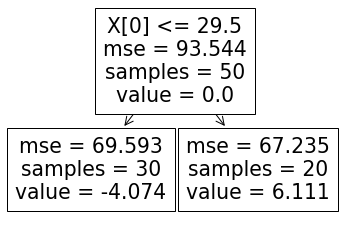

In [285]:
plot_tree(model.base_models[0])

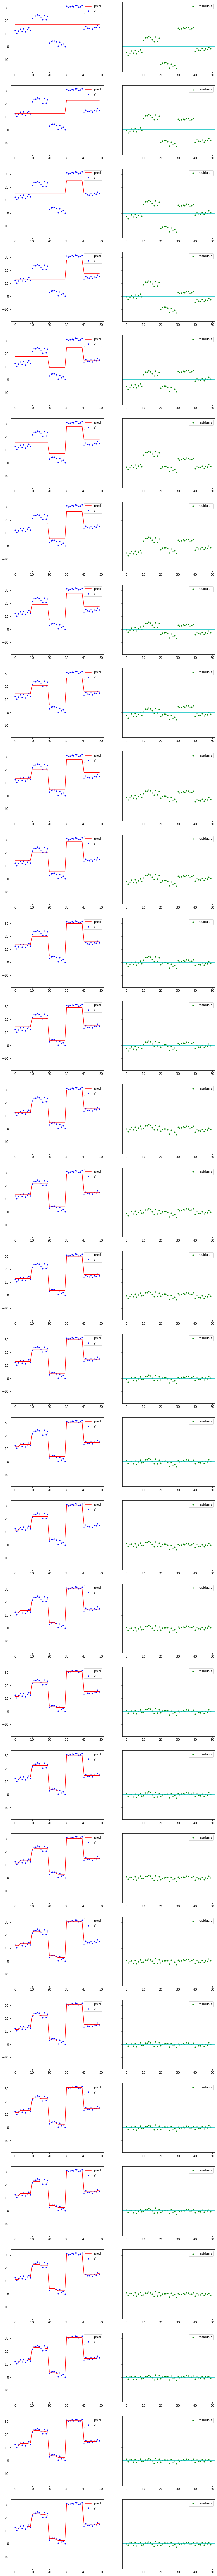

In [179]:
model.plot_steps()

In [88]:
df = pd.DataFrame({'x' : X[:,0], 'y' : y})

for i in range(model.predictions.shape[0]):
    p = model.predictions[i]
    r = model.residuals[i]
    
    df['pred_'+str(i)] = p
    df['res_'+str(i)] = r
    
df






,x,y,pred_0,res_0,pred_1,res_1,pred_2,res_2,pred_3,res_3,...,pred_6,res_6,pred_7,res_7,pred_8,res_8,pred_9,res_9,pred_10,res_10
0,0.0,0.000000,-0.000111,-0.000111,-0.625081,-0.625081,-1.875020,-1.875020,-4.374899,-4.374899,...,-39.373206,-39.373206,-79.371271,-79.371271,-159.367400,-159.367400,-319.359659,-319.359659,-639.344177,-639.344177
1,0.1,0.099833,-0.000111,-0.099944,-0.625081,-0.724914,-1.875020,-1.974854,-4.374899,-4.474733,...,-39.373206,-39.473039,-79.371271,-79.471104,-159.367400,-159.467234,-319.359659,-319.459492,-639.344177,-639.444010
2,0.2,0.198669,-0.000111,-0.198780,-0.625081,-0.823750,-1.875020,-2.073690,-4.374899,-4.573569,...,-39.373206,-39.571875,-79.371271,-79.569940,-159.367400,-159.566069,-319.359659,-319.558328,-639.344177,-639.542846
3,0.3,0.295520,-0.000111,-0.295631,-0.625081,-0.920601,-1.875020,-2.170541,-4.374899,-4.670420,...,-39.373206,-39.668726,-79.371271,-79.666791,-159.367400,-159.662920,-319.359659,-319.655179,-639.344177,-639.639697
4,0.4,0.389418,-0.000111,-0.389529,-0.625081,-1.014499,-1.875020,-2.264439,-4.374899,-4.764318,...,-39.373206,-39.762624,-79.371271,-79.760689,-159.367400,-159.756818,-319.359659,-319.749077,-639.344177,-639.733595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,5.8,-0.464602,-0.000111,0.464491,0.645019,1.109621,1.935279,2.399881,4.515800,4.980402,...,40.643084,41.107686,81.931409,82.396011,164.508058,164.972661,329.661358,330.125960,659.967957,660.432559
59,5.9,-0.373877,-0.000111,0.373766,0.645019,1.018896,1.935279,2.309156,4.515800,4.889676,...,40.643084,41.016960,81.931409,82.305285,164.508058,164.881935,329.661358,330.035234,659.967957,660.341833
60,6.0,-0.279415,-0.000111,0.279304,0.645019,0.924435,1.935279,2.214695,4.515800,4.795215,...,40.643084,40.922499,81.931409,82.210824,164.508058,164.787474,329.661358,329.940773,659.967957,660.247372
61,6.1,-0.182163,-0.000111,0.182051,0.645019,0.827182,1.935279,2.117442,4.515800,4.697962,...,40.643084,40.825246,81.931409,82.113571,164.508058,164.690221,329.661358,329.843520,659.967957,660.150119
